# Covid19 Image Classification - Phase 2  

__Abstract:__ Our Aim is to detect Covid19 from chest X-rays. The covid19 image dataset is small with 251 training and 60 test images belonging to 'NoFinding', 'Covid19' and 'Pneumonia' respectively. This dataset small and is insufficient to generalize. So for the purpoe of our project, in Phase-I we will first use NIH X-ray image data to retrain and finetune pretrained model architecture such as ResNet50V2, MobileNetV2 and VGG16.

Following the results from phase 1, we selected the best model to be ______ and in phase2 we will focus on classifing our target dataset of covid images

In [2]:
# common imports
import os
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from glob import glob
from pathlib import Path
from functools import partial

from sklearn.model_selection import train_test_split

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# prevent VRAM occupied
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

from keras.applications.resnet_v2 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

In [3]:
#change working directory  - as the images are located in data/raw in the project folder (Execute this cell Once)

if '/notebooks' in os.getcwd():
    os.chdir("../")
    print("set the project directory as working directory")
else:
    print(os.getcwd())

set the project directory as working directory


In [4]:
# Import functions for trianing the model
%load_ext autoreload
%autoreload 2
import src.models.train_model as train_model

# load tensorboard extension
%reload_ext tensorboard

In [5]:
# Constants
SEED =42
IMAGE_SIZE = (224,224)
IMAGE_SHAPE = (224,224,3)
BATCH_SIZE = 32
SHUFFLE = True
TARGET_WIDTH= 224
TARGET_HEGIHT =224
NUM_CLASSES = 3 # number of ClassesNUM
NUM_EPOCHS = 10
log_folder = 'logs' # logs folder

## Preprocess Images

In [6]:
BATCH_SIZE =1

covid_image_train_data_gen = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    validation_split=0.2,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=True, #Boolean. Set each sample mean to 0.
    samplewise_std_normalization = False, #Boolean. Divide each input by its std.
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    horizontal_flip = True, #Boolean. Randomly flip inputs horizontally.
    vertical_flip = False,  #Boolean. Randomly flip inputs vertically.
    zca_whitening=False,  # apply ZCA whitening
    height_shift_range= 0.05, #float: fraction of total height, if < 1, or pixels if >= 1.
    width_shift_range=0.1,  #float: fraction of total height, if < 1, or pixels if >= 1.
    rotation_range=20, #Int. Degree range for random rotations. 0 -180 degrees
    shear_range = 0.1, #Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    fill_mode = 'nearest', #One of {"constant", "nearest", "reflect" or "wrap"}. Default is 'nearest'. 
    zoom_range=0.15) #Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]


# covid_image_test_data_gen = ImageDataGenerator(
#     preprocessing_function= preprocess_input,
#     featurewise_center=False,  # set input mean to 0 over the dataset
#     samplewise_center=True, #Boolean. Set each sample mean to 0.
#     samplewise_std_normalization = False, #Boolean. Divide each input by its std.
#     featurewise_std_normalization=False, # divide inputs by std of the dataset
#     horizontal_flip = True, #Boolean. Randomly flip inputs horizontally.
#     vertical_flip = False,  #Boolean. Randomly flip inputs vertically.
#     zca_whitening=False,  # apply ZCA whitening
#     height_shift_range= 0.05, #float: fraction of total height, if < 1, or pixels if >= 1.
#     width_shift_range=0.1,  #float: fraction of total height, if < 1, or pixels if >= 1.
#     rotation_range=20, #Int. Degree range for random rotations. 0 -180 degrees
#     shear_range = 0.1, #Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
#     fill_mode = 'nearest', #One of {"constant", "nearest", "reflect" or "wrap"}. Default is 'nearest'. 
#     zoom_range=0.15) #Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]


covid_train_ds = covid_image_train_data_gen.flow_from_directory(
  'data/raw/covid19-images',
  subset="training",
  class_mode='categorical',
  #classes=['Covid19', 'Normal', 'Pneumonia'],
  seed=SEED,
  target_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

covid_valid_ds = covid_image_train_data_gen.flow_from_directory(
  'data/raw/covid19-images',
  subset="validation",
  #classes=['Covid19', 'Normal', 'Pneumonia'],
  class_mode='categorical',
  seed=SEED,
  target_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

# covid_test_generator = covid_image_test_data_gen.flow_from_directory(
#   'data/raw/Covid19-dataset/test/',
#   class_mode='categorical',
#   classes=['Covid', 'Normal', 'Viral Pneumonia'],
#   seed=SEED,
#   target_size=IMAGE_SIZE,
#   batch_size=BATCH_SIZE)

Found 2995 images belonging to 3 classes.
Found 748 images belonging to 3 classes.


## Reload and train the Saved Model

In [7]:
def train_validate_and_test_reconstructed_model(saved_model_path: str,
                                                model_name: str,
                                                covid_train_ds,
                                                covid_valid_ds,
                                                #freeze_layers: bool = False,
                                                num_classes: int = 3,
                                                num_epochs: int = 10,
                                                batch_size: int = 32,
                                                activation_func: str = 'softmax',
                                                learning_rate: float = 0.001,
                                                ft_learning_rate: float = 0.00001,
                                                unfreeze_at_layer: int = 0):

    # It can be used to reconstruct the model identically.
    reconstructed_model = keras.models.load_model(saved_model_path)

    new_layer = reconstructed_model.layers[-2].output
#     new_layer = keras.layers.Dense(256, activation="relu")(new_layer)
#     new_layer = keras.layers.Dropout(0.3)(new_layer)
    output = keras.layers.Dense(
        num_classes, activation=activation_func, name='output')(new_layer)
    new_model = keras.Model(inputs=reconstructed_model.input, outputs=output)
    new_model = train_model.compile_classifier(new_model, learning_rate)

    new_model_history = train_model.fit_model(
        new_model, covid_train_ds, covid_valid_ds, num_epochs=num_epochs, batch_size=batch_size, patience=10)

    print(f'{model_name} Accuracy and Loss plots')
    train_model.plot_accuracy_and_loss(new_model_history)

    print("\n")
    # fine_tune model_name
    new_model_ft = train_model.fine_tune_model(
        new_model, ft_learning_rate, optimizer='Adam', fine_tune_at_layer=unfreeze_at_layer)

    print("\n")
    print(f'Fine-Tuned {model_name} Training and Validation: ')
    new_model_ft_history = train_model.fit_model(new_model_ft, covid_train_ds,
                                                 covid_valid_ds,
                                                 num_epochs=num_epochs, batch_size=batch_size)

    print(f'Fine-Tuned {model_name} Accuracy and Loss plots')
    train_model.plot_accuracy_and_loss(new_model_ft_history)


# Covid19 Image Classification - Phase 2

## Experiement 1 - Classification (softmax) Pretrained on NIH Xray images - all layers unfrozen with lower learning rate (0.00001)

Epoch 1/10
93/93 [==============================] - 5s 34ms/step - loss: 12.7697 - accuracy: 0.6452 - val_loss: 3.1806 - val_accuracy: 0.8696

Epoch 00001: val_loss improved from inf to 3.18064, saving model to models/my_model.h5
Epoch 2/10
93/93 [==============================] - 2s 25ms/step - loss: 7.6919 - accuracy: 0.8280 - val_loss: 4.6346 - val_accuracy: 0.8696

Epoch 00002: val_loss did not improve from 3.18064
Epoch 3/10
93/93 [==============================] - 2s 24ms/step - loss: 5.6019 - accuracy: 0.8602 - val_loss: 5.9141 - val_accuracy: 0.8696

Epoch 00003: val_loss did not improve from 3.18064
Epoch 4/10
93/93 [==============================] - 2s 23ms/step - loss: 2.9752 - accuracy: 0.8817 - val_loss: 1.8346 - val_accuracy: 0.9130

Epoch 00004: val_loss improved from 3.18064 to 1.83459, saving model to models/my_model.h5
Epoch 5/10
93/93 [==============================] - 2s 24ms/step - loss: 4.6393 - accuracy: 0.8710 - val_loss: 4.3582 - val_accuracy: 0.8261

Epoch 000

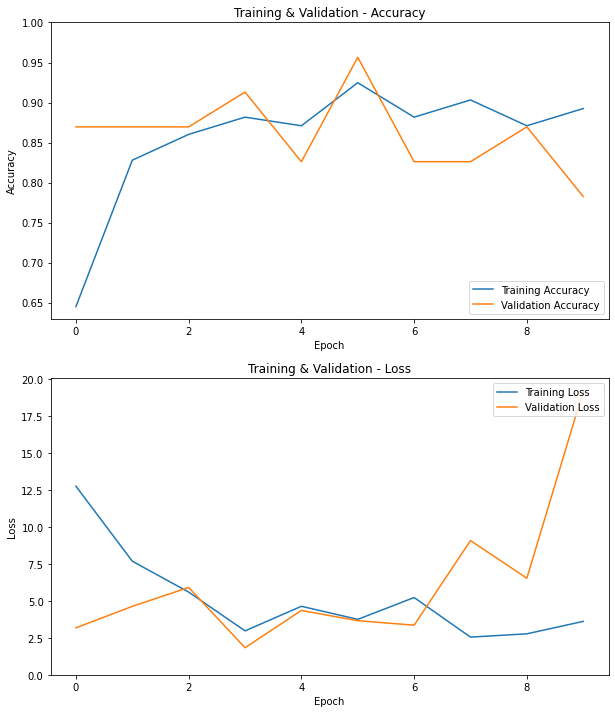





Fine-Tuned ResNet50V2 Training and Validation: 
Epoch 1/10
93/93 [==============================] - 8s 54ms/step - loss: 14.7524 - accuracy: 0.3871 - val_loss: 8.5912 - val_accuracy: 0.8261

Epoch 00001: val_loss improved from inf to 8.59124, saving model to models/my_model.h5
Epoch 2/10
93/93 [==============================] - 4s 39ms/step - loss: 3.1070 - accuracy: 0.6774 - val_loss: 1.6123 - val_accuracy: 0.8696

Epoch 00002: val_loss improved from 8.59124 to 1.61230, saving model to models/my_model.h5
Epoch 3/10
93/93 [==============================] - 4s 39ms/step - loss: 1.8540 - accuracy: 0.7097 - val_loss: 3.4144 - val_accuracy: 0.7391

Epoch 00003: val_loss did not improve from 1.61230
Epoch 4/10
93/93 [==============================] - 4s 39ms/step - loss: 2.1237 - accuracy: 0.6559 - val_loss: 4.6320 - val_accuracy: 0.6957

Epoch 00004: val_loss did not improve from 1.61230
Epoch 5/10
93/93 [==============================] - 4s 38ms/step - loss: 2.0460 - accuracy: 0.6989 

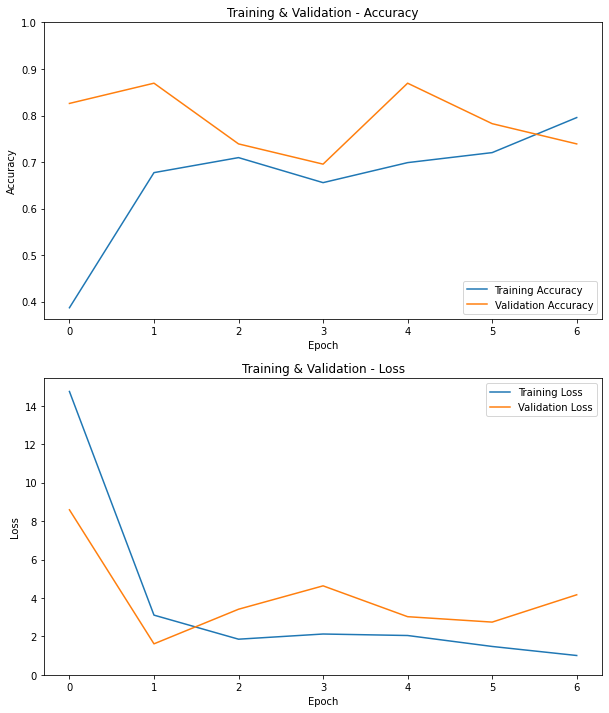

In [8]:

train_validate_and_test_reconstructed_model('models/ResNet50V2exp1.h5', 'ResNet50V2', covid_train_ds, covid_valid_ds)


## Experiement 2 - Classification (softmax) Pretrained on NIH Xray images - unfrozen at and above layers #186 with lower learning rate (0.00001)

Epoch 1/10
93/93 [==============================] - 5s 35ms/step - loss: 9.6868 - accuracy: 0.6559 - val_loss: 7.2562e-08 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.00000, saving model to models/my_model.h5
Epoch 2/10
93/93 [==============================] - 2s 21ms/step - loss: 8.8503 - accuracy: 0.7849 - val_loss: 2.4160 - val_accuracy: 0.9565

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/10
93/93 [==============================] - 2s 23ms/step - loss: 2.5931 - accuracy: 0.8925 - val_loss: 10.5274 - val_accuracy: 0.8261

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/10
93/93 [==============================] - 2s 22ms/step - loss: 1.9822 - accuracy: 0.9140 - val_loss: 0.8214 - val_accuracy: 0.9130

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/10
93/93 [==============================] - 2s 23ms/step - loss: 1.7313 - accuracy: 0.9140 - val_loss: 4.3113 - val_accuracy: 0.9130

Epoch 00005: val_loss did not improve from 0.

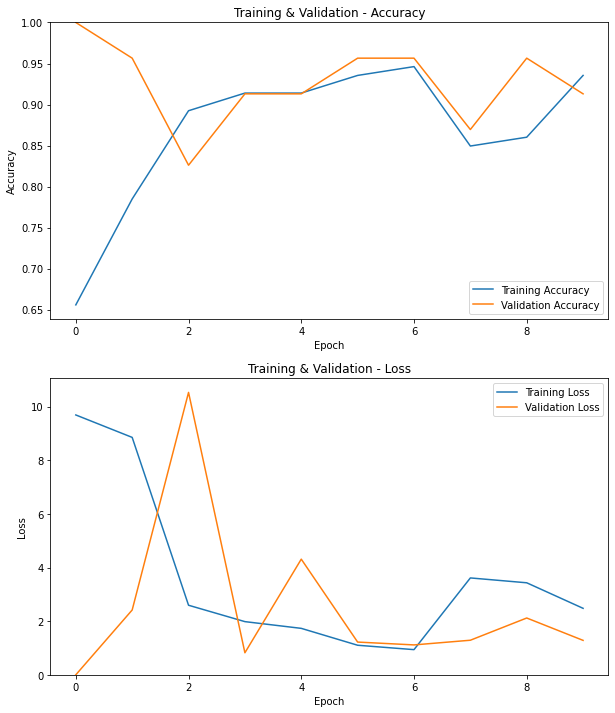





Fine-Tuned ResNet50V2 Training and Validation: 
Epoch 1/10
93/93 [==============================] - 5s 34ms/step - loss: 7.2978 - accuracy: 0.6989 - val_loss: 0.4097 - val_accuracy: 0.9565

Epoch 00001: val_loss improved from inf to 0.40973, saving model to models/my_model.h5
Epoch 2/10
93/93 [==============================] - 2s 23ms/step - loss: 3.5142 - accuracy: 0.8065 - val_loss: 0.4360 - val_accuracy: 0.9565

Epoch 00002: val_loss did not improve from 0.40973
Epoch 3/10
93/93 [==============================] - 2s 23ms/step - loss: 3.7817 - accuracy: 0.8065 - val_loss: 4.9041 - val_accuracy: 0.8261

Epoch 00003: val_loss did not improve from 0.40973
Epoch 4/10
93/93 [==============================] - 2s 23ms/step - loss: 2.8901 - accuracy: 0.8387 - val_loss: 1.8067 - val_accuracy: 0.9565

Epoch 00004: val_loss did not improve from 0.40973
Epoch 5/10
93/93 [==============================] - 2s 21ms/step - loss: 1.8206 - accuracy: 0.8172 - val_loss: 3.2938 - val_accuracy: 0.8696

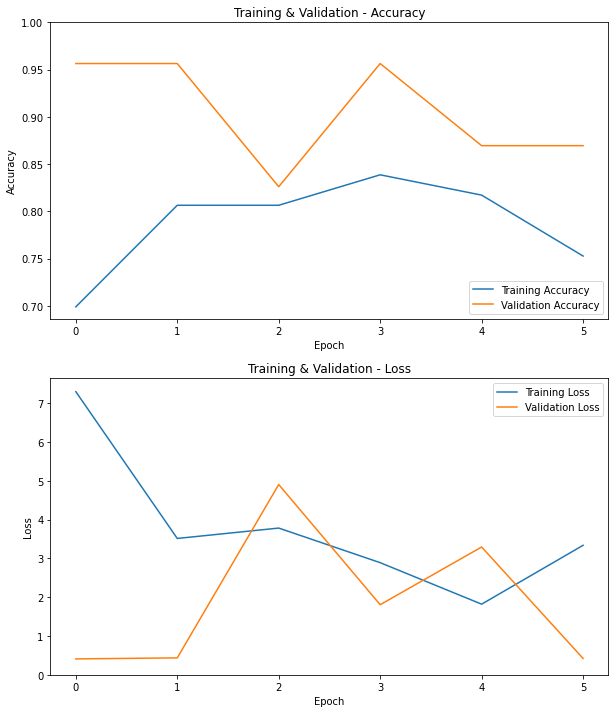

In [9]:
train_validate_and_test_reconstructed_model('models/ResNet50V2exp1.h5', 'ResNet50V2', covid_train_ds, covid_valid_ds, unfreeze_at_layer=186)

## Training and Validating ResNet50V2 on Covid19 dataset with no transfer learning

In [12]:
# Constants
SEED =42
IMAGE_SIZE = (224,224)
IMAGE_SHAPE = (224,224,3)
BATCH_SIZE = 32
SHUFFLE = True
NUM_CLASSES = 15 # number of ClassesNUM
NUM_EPOCHS = 10
PRETRAINED_MODELS = ['ResNet50V2', 'MobileNetV2', 'VGG16']

# Train and validate function
def train_and_validate_model(model_name,
                             train_generator, 
                             valid_generator, 
                             save_model_filepath: str,
                             logs_dir: str,
                             patience: int =5,
                             freeze_layers:bool = True, 
                             activation: str = 'softmax', 
                             learning_rate: float =0.01, 
                             fine_tune_learning_rate: float = 0.0001,
                             unfreeze_at_layer:int = 186,
                             num_epochs:int = NUM_EPOCHS,
                             num_classes: int = NUM_CLASSES,
                             batch_size: int = BATCH_SIZE,
                             input_shape: int = IMAGE_SHAPE):
    
    print(model_name)
    
    my_model = train_model.get_base_model_with_new_toplayer(base_model=model_name,
                                                          freeze_layers = freeze_layers, 
                                                          num_classes = num_classes,
                                                          activation_func=activation,
                                                          learning_rate = learning_rate,
                                                          input_shape = input_shape)

    my_model_history = train_model.fit_model(my_model, 
                                             train_generator, 
                                             valid_generator,
                                             num_epochs=num_epochs,
                                             batch_size=batch_size,
                                             checkpoint_filepath=save_model_filepath,
                                             logs_dir = logs_dir,
                                             patience = patience)

    print(f'{model_name} Accuracy and Loss plots')
    train_model.plot_accuracy_and_loss(my_model_history)


    print("\n")
    #fine_tune model_name
    model_ft = train_model.fine_tune_model(my_model,
                                           fine_tune_learning_rate,
                                           optimizer='Adam',
                                           fine_tune_at_layer=unfreeze_at_layer,
                                           activation_func=activation)
    
    
    print("\n")
    print(f'Fine-Tuned {model_name} Training and Validation: ')
    model_ft_history = train_model.fit_model(model_ft, train_generator, 
            valid_generator, num_epochs=num_epochs,batch_size=batch_size)
    print(f'Fine-Tuned {model_name} Accuracy and Loss plots')
    train_model.plot_accuracy_and_loss(model_ft_history)
    return model_ft

ResNet50V2
learning rate 0.01
Epoch 1/10
93/93 [==============================] - 5s 34ms/step - loss: 78.0182 - accuracy: 0.6882 - val_loss: 92.0631 - val_accuracy: 0.7391

Epoch 00001: val_loss improved from inf to 92.06310, saving model to models/Covid19ResNet50V2exp1.h5
Epoch 2/10
93/93 [==============================] - 2s 23ms/step - loss: 63.7665 - accuracy: 0.8065 - val_loss: 16.8798 - val_accuracy: 0.9565

Epoch 00002: val_loss improved from 92.06310 to 16.87977, saving model to models/Covid19ResNet50V2exp1.h5
Epoch 3/10
93/93 [==============================] - 2s 24ms/step - loss: 98.8307 - accuracy: 0.8280 - val_loss: 75.3243 - val_accuracy: 0.7826

Epoch 00003: val_loss did not improve from 16.87977
Epoch 4/10
93/93 [==============================] - 2s 23ms/step - loss: 104.1747 - accuracy: 0.7742 - val_loss: 54.0307 - val_accuracy: 0.8696

Epoch 00004: val_loss did not improve from 16.87977
Epoch 5/10
93/93 [==============================] - 2s 22ms/step - loss: 55.7584 -

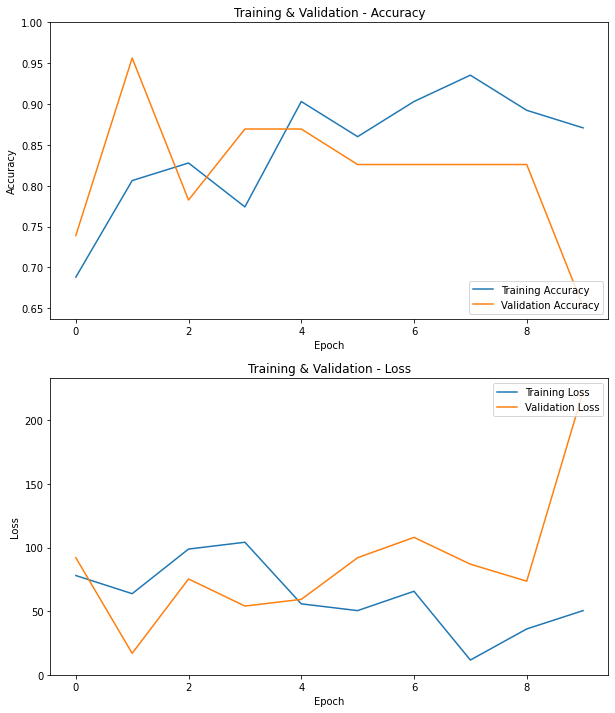





Fine-Tuned ResNet50V2 Training and Validation: 
Epoch 1/10
93/93 [==============================] - 5s 34ms/step - loss: 47.3965 - accuracy: 0.6882 - val_loss: 84.7082 - val_accuracy: 0.9130

Epoch 00001: val_loss improved from inf to 84.70823, saving model to models/my_model.h5
Epoch 2/10
93/93 [==============================] - 2s 23ms/step - loss: 18.9182 - accuracy: 0.9032 - val_loss: 50.8466 - val_accuracy: 0.8261

Epoch 00002: val_loss improved from 84.70823 to 50.84664, saving model to models/my_model.h5
Epoch 3/10
93/93 [==============================] - 2s 23ms/step - loss: 22.8372 - accuracy: 0.8710 - val_loss: 22.9755 - val_accuracy: 0.8696

Epoch 00003: val_loss improved from 50.84664 to 22.97551, saving model to models/my_model.h5
Epoch 4/10
93/93 [==============================] - 2s 23ms/step - loss: 20.2843 - accuracy: 0.8710 - val_loss: 94.4585 - val_accuracy: 0.8696

Epoch 00004: val_loss did not improve from 22.97551
Epoch 5/10
93/93 [============================

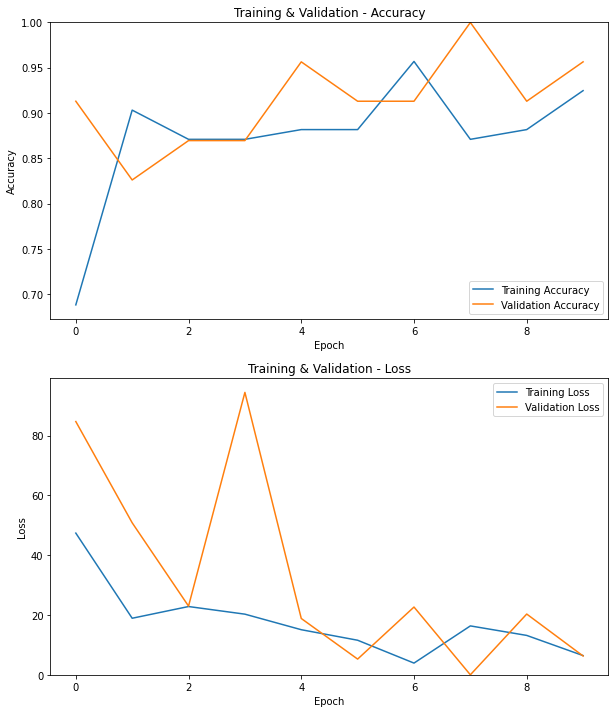

In [13]:
model_name = 'ResNet50V2'
save_model_filepath = 'models/Covid19'+ model_name + 'exp1.h5'
logs_dir = 'logs/fit/Covid19ResNet50V2exp1'
model = train_and_validate_model(model_name = model_name, 
                                 train_generator=covid_train_ds, 
                                 valid_generator=covid_valid_ds, 
                                 save_model_filepath=save_model_filepath,
                                 logs_dir=logs_dir,
                                 num_classes=3, 
                                 num_epochs=10,
                                 patience=10)


In [ ]:
# clear gpu memory
from numba import cuda 
device = cuda.get_current_device()
device.reset()